In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb 
sb.set_style("whitegrid", {'axes.grid' : False})

In [2]:
lifetime = pd.read_csv('Courier_lifetime_data.csv')
weekly = pd.read_csv('Courier_weekly_data.csv')


In [3]:
merge = pd.merge(lifetime, weekly, on='courier', how='left') #.to_csv('merge.csv')


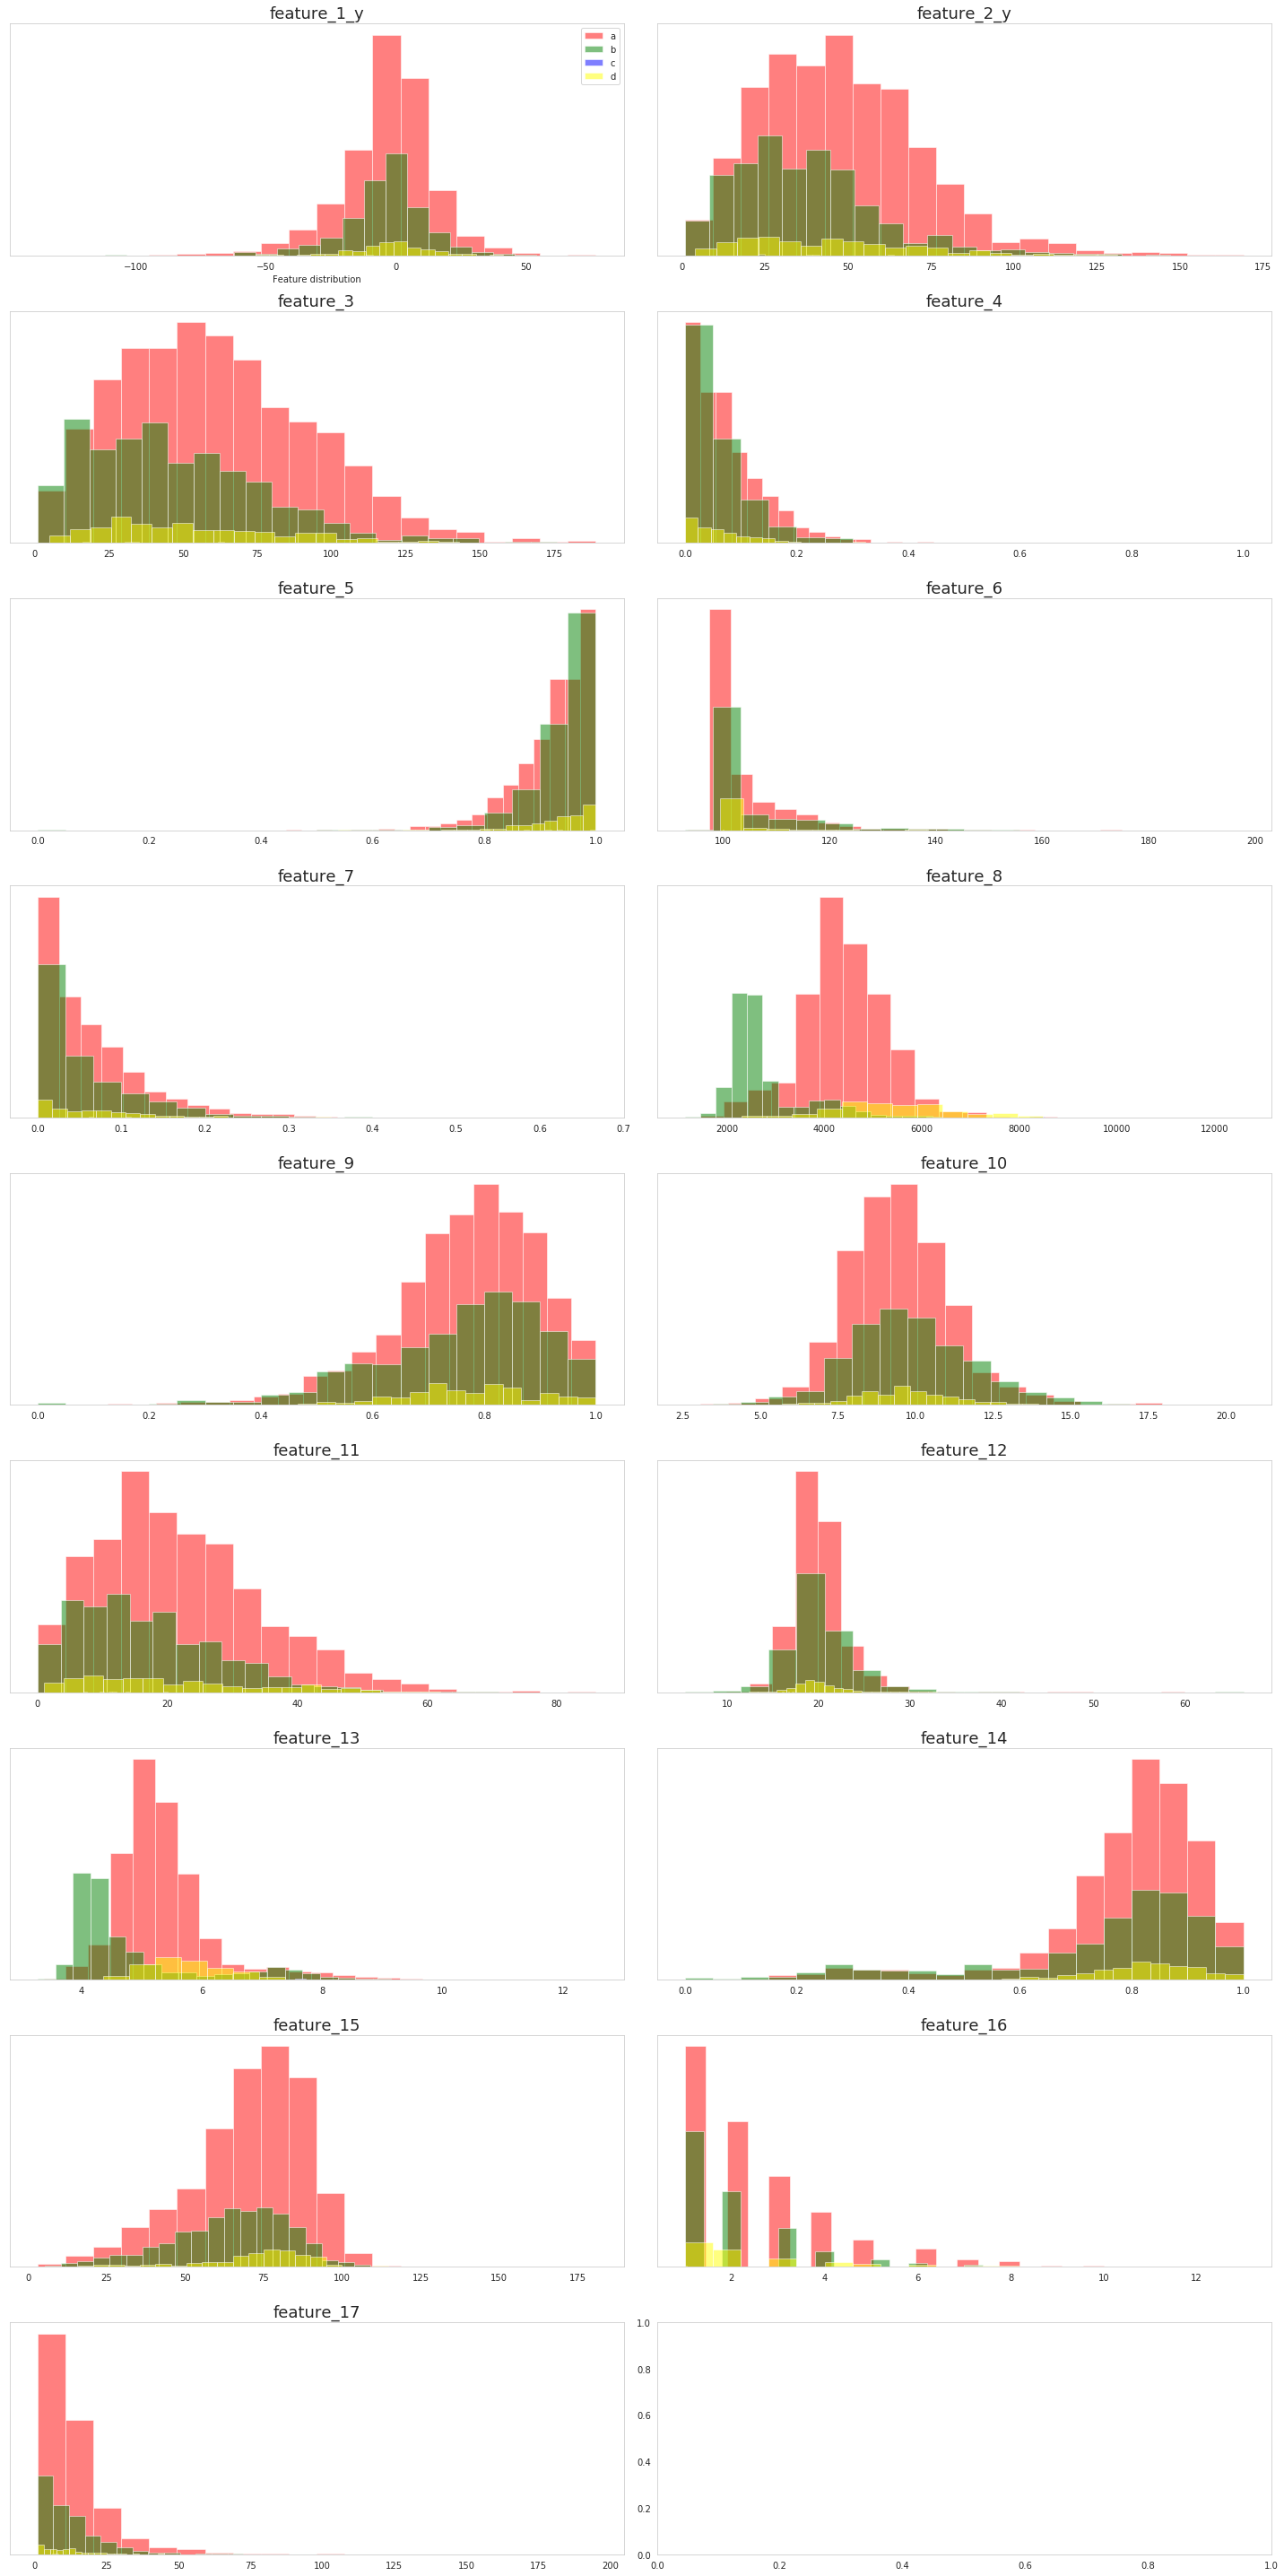

In [6]:

a = merge.loc[merge.feature_1_x=='a']
b = merge.loc[merge.feature_1_x=='b']
c = merge.loc[merge.feature_1_x=='c']
d = merge.loc[merge.feature_1_x=='d']

features = ['feature_1_y',
       'feature_2_y', 'feature_3', 'feature_4', 'feature_5', 'feature_6',
       'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11',
       'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16',
       'feature_17']

fig, axes = plt.subplots(9, 2, figsize=(20,40))

ax = axes.flatten() #ravel()

for i in range(len(features)):
    ax[i].hist(a.loc[:,features[i]], bins=20, color='red', alpha=.5)
    ax[i].hist(b.loc[:,features[i]], bins=20, color='green', alpha=.5)
    ax[i].hist(c.loc[:,features[i]], bins=20, color='blue', alpha=.5)
    ax[i].hist(d.loc[:,features[i]], bins=20, color='yellow', alpha=.5)
    ax[i].set_title(features[i], fontsize=18)
    ax[i].set_yticks(())
    
ax[0].set_xlabel("Feature distribution")
ax[0].legend(["a", "b", "c", "d"], loc="best")
fig.tight_layout()


plt.show()

In [ ]:
#Use KNN for missing value imputation based on lifetime data: feature_1 and feature_2:

#First impute feature_2 ( Do this separately for a, b, c and d ? Or for the whole merge dataframe?)
#Then I can use both feature 1 and 2 from lifetime to impute the weekly features

#create training and target sets :
X = np.matrix(merge.dropna()[features])
y = np.matrix(merge['feature_2_x'].dropna())

#k = 5 by default
regr = KNeighborsRegressor().fit(X, y.transpose())
feature_2_x_ = regr.predict(np.matrix(merge[features]))#[:, 'feature_2_x']
merge['feature_2_x_'] = [int(i) for i in feature_2_x_]
